In [1]:
import os
from zipfile import ZipFile
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import regularizers


In [ ]:
# Hyperparameters
image_size = (200, 200)
batch_size = 32
num_epochs = 20


In [ ]:
# Extract the dataset from ZIP file
file_name = '//content/dataset.zip'
with ZipFile(file_name, 'r') as zip:
    zip.extractall()
    print('Dataset extracted successfully')

Dataset extracted successfully


In [ ]:
# Path ke dataset
dataset_dir = '/content/dataset/train'
test_data_dir = '/content/dataset/test'

In [ ]:
# List classes
classes = ['cow_disease', 'cow_healthy', 'goat_disease', 'goat_healthy']

In [ ]:
# Function to load and preprocess the dataset
def load_dataset():
    images = []
    labels = []

    for class_index, class_name in enumerate(classes):
        class_dir = os.path.join(dataset_dir, class_name)
        for image_name in os.listdir(class_dir):
            image_path = os.path.join(class_dir, image_name)
            image = cv2.imread(image_path)
            image = cv2.resize(image, image_size)
            images.append(image)
            labels.append(class_index)

    images = np.array(images)
    labels = np.array(labels)

    # Split the dataset into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

    # Convert the labels to categorical
    y_train = tf.keras.utils.to_categorical(y_train, num_classes=len(classes))
    y_test = tf.keras.utils.to_categorical(y_test, num_classes=len(classes))

    return X_train, X_test, y_train, y_test

In [ ]:
# Load and preprocess dataset
X_train, X_test, y_train, y_test = load_dataset()

In [ ]:
# Create data generator with data augmentation
data_generator = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)

In [ ]:
# Preprocess dataset train and test
train_generator = data_generator.flow(X_train, y_train, batch_size=batch_size)
test_generator = data_generator.flow(X_test, y_test, batch_size=batch_size)

In [ ]:
# Create the CNN model
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(image_size[0], image_size[1], 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(len(classes), activation='softmax'))

model.summary()

In [ ]:
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# Train the model using data generator
history = model.fit(train_generator, epochs=num_epochs,
                    validation_data=test_generator)

Epoch 1/20
29/29 [==============================] - 12s 349ms/step - loss: 1.8458 - accuracy: 0.2842 - val_loss: 1.3703 - val_accuracy: 0.2533
Epoch 2/20
29/29 [==============================] - 10s 349ms/step - loss: 1.3168 - accuracy: 0.3454 - val_loss: 1.3067 - val_accuracy: 0.3799
Epoch 3/20
29/29 [==============================] - 10s 346ms/step - loss: 1.2499 - accuracy: 0.4317 - val_loss: 1.2404 - val_accuracy: 0.5328
Epoch 4/20
29/29 [==============================] - 10s 357ms/step - loss: 1.1871 - accuracy: 0.4579 - val_loss: 1.0746 - val_accuracy: 0.6070
Epoch 5/20
29/29 [==============================] - 10s 335ms/step - loss: 1.1087 - accuracy: 0.5617 - val_loss: 0.9571 - val_accuracy: 0.6157
Epoch 6/20
29/29 [==============================] - 10s 340ms/step - loss: 1.0475 - accuracy: 0.5749 - val_loss: 1.0628 - val_accuracy: 0.5590
Epoch 7/20
29/29 [==============================] - 10s 342ms/step - loss: 1.0173 - accuracy: 0.6066 - val_loss: 0.9062 - val_accuracy: 0.6550

In [ ]:
# Evaluate model
loss, accuracy = model.evaluate(test_generator)
print('Test loss:', loss)
print('Test accuracy:', accuracy)

8/8 [==============================] - 2s 215ms/step - loss: 0.6236 - accuracy: 0.7729
Test loss: 0.6235792636871338
Test accuracy: 0.7729257345199585


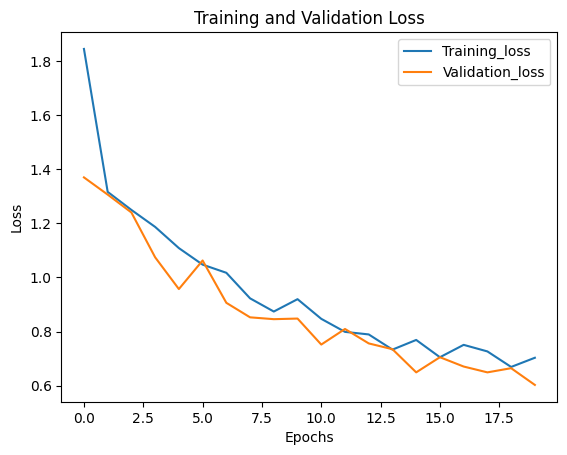

In [ ]:
import matplotlib.pyplot as plt
# Plot the training and validation loss
plt.plot(history.history['loss'], label='Training_loss')
plt.plot(history.history['val_loss'], label='Validation_loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

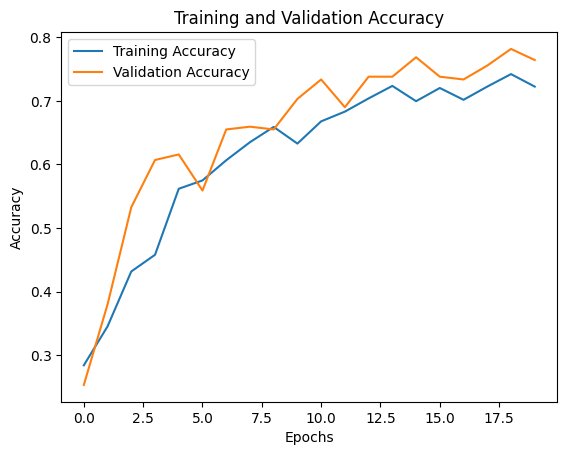

In [ ]:
# Plot the training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()


In [ ]:
#save the trained model
model.save('livestock_disease_model.h5')

## Load Model

In [ ]:
from tensorflow.keras.models import load_model

model = load_model('livestock_disease_model.h5')

converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

print("model converted")

#save model
with open('model.tflite', 'wb') as f:
  f.write(tflite_model)

model converted


In [ ]:
def preprocess_image(image_path, image_size):
    image = cv2.imread(image_path)
    image = cv2.resize(image, image_size)
    image = image / 255.0  # Normalize the image
    return image

image_path = '/content/dataset/test/goat_healthy/goat12_jpg.rf.4d99530ced407be0b68f5d74e9138322.jpg'  # Replace with the actual image path
image = preprocess_image(image_path, image_size)


In [ ]:
image = np.reshape(image, (1, image_size[0], image_size[1], 3))
prediction = model.predict(image)
predicted_class = np.argmax(prediction[0])
class_name = classes[predicted_class]
print('Predicted class:', class_name)



1/1 [==============================] - 0s 19ms/step
Predicted class: cow_healthy
